# Federated Learning with Pytorch Backend

>The following codes are demos only. It's **NOT for production** due to system security concerns, please **DO NOT** use it directly in production.

In this tutorial, We will walk you through how to use pytorch backend on SecretFlow for federated learning.  

+ We will use the image clasification task as example
+ Use pytorch as backend
+ We will show how to use multi fl strategy
  
If you want to learn more about federated learning, datasets, etc., you can move to [Federated Learning for Image Classification](Federate_Learning_for_Image_Classification.ipynb).
  
**Here we go!**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# process_utils.py
import psutil
import os
import platform


def find_process_by_port(port):
    for proc in psutil.process_iter(["pid", "name"]):
        try:
            connections = proc.connections(kind="inet")
            for conn in connections:
                if conn.laddr.port == port:
                    return proc.pid
        except (psutil.AccessDenied, psutil.NoSuchProcess):
            continue
    return None


def kill_process(pid):
    try:
        if platform.system() == "Windows":
            os.system(f"taskkill /PID {pid} /F")
        else:
            os.system(f"kill -9 {pid}")
        print(f"Process with PID {pid} has been terminated.")
    except Exception as e:
        print(f"Error terminating process with PID {pid}: {e}")


def kill_port_process(port: int):
    pid = find_process_by_port(port)

    if pid:
        print(f"Process found using port {port}: PID {pid}")
        kill_process(pid)
    else:
        print(f"No process found using port {port}")


pyu_port = 16307
spu_port = 11666

kill_port_process(port=pyu_port)
kill_port_process(port=spu_port)

import secretflow as sf

# Check the version of your SecretFlow
print("The version of SecretFlow: {}".format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

pyu_port = 16307
spu_port = 11666


cluster_config = {
    "parties": {
        "alice": {
            # replace with alice's real address.
            "address": "ecm-01:" + str(pyu_port),
            "listen_addr": "0.0.0.0:" + str(pyu_port),
        },
        "bob": {
            # replace with bob's real address.
            "address": "ecm-02:" + str(pyu_port),
            "listen_addr": "0.0.0.0:" + str(pyu_port),
        },
    },
    "self_party": "bob",
}

tls_config = {
    "ca_cert": "/home/beng003/certificate/alice_ca.crt",
    "cert": "/home/beng003/certificate/bob_server_cert.crt",
    "key": "/home/beng003/certificate/bob_server_key.key",
}


sf.init(address="ecm-02:6379", cluster_config=cluster_config, tls_config=tls_config)
alice = sf.PYU("alice")
bob = sf.PYU("bob")
print("Alice and Bob are ready to go!")

/tmp/ipykernel_3013622/1420835607.py:10: DeprecationWarning: connections() is deprecated and will be removed; use net_connections() instead
  connections = proc.connections(kind="inet")


No process found using port 16307
No process found using port 11666


2024-08-12 19:49:34,505	INFO worker.py:1540 -- Connecting to existing Ray cluster at address: ecm-02:6379...
2024-08-12 19:49:34,516	INFO worker.py:1724 -- Connected to Ray cluster.
2024-08-12 19:49:34.544 INFO api.py:233 [bob] -- [Anonymous_job] Started rayfed with {'CLUSTER_ADDRESSES': {'alice': 'ecm-01:16307', 'bob': '0.0.0.0:16307'}, 'CURRENT_PARTY_NAME': 'bob', 'TLS_CONFIG': {'ca_cert': '/home/beng003/certificate/alice_ca.crt', 'cert': '/home/beng003/certificate/bob_server_cert.crt', 'key': '/home/beng003/certificate/bob_server_key.key'}}


The version of SecretFlow: 1.7.0b0


2024-08-12 19:49:35.647 INFO barriers.py:284 [bob] -- [Anonymous_job] Succeeded to create receiver proxy actor.
(ReceiverProxyActor pid=3013745) 2024-08-12 19:49:35.642 INFO grpc_proxy.py:359 [bob] -- [Anonymous_job] ReceiverProxy binding port 16307, options: (('grpc.enable_retries', 1), ('grpc.so_reuseport', 0), ('grpc.max_send_message_length', 524288000), ('grpc.max_receive_message_length', 524288000), ('grpc.service_config', '{"methodConfig": [{"name": [{"service": "GrpcService"}], "retryPolicy": {"maxAttempts": 5, "initialBackoff": "5s", "maxBackoff": "30s", "backoffMultiplier": 2, "retryableStatusCodes": ["UNAVAILABLE"]}}]}'))...
(ReceiverProxyActor pid=3013745) 2024-08-12 19:49:35.646 INFO grpc_proxy.py:379 [bob] -- [Anonymous_job] Successfully start Grpc service with credentials.
2024-08-12 19:49:36.596 INFO barriers.py:333 [bob] -- [Anonymous_job] SenderProxyActor has successfully created.
2024-08-12 19:49:36.597 INFO barriers.py:520 [bob] -- [Anonymous_job] Try ping ['alice'] 

Alice and Bob are ready to go!


### Here, let us first introduce some concepts
BaseModule: Similar to the `torch.nn.module`.    
TorchModel: A wrap class include `loss_fn`,`optim_fn`,`model_def`,`metrics`.  
metric_wrapper: Wrap metrics to workers.  
optim_wrapper: Wrap optim_fn to workers.  
FLModel: Federated model, use `backend` to specify which bachend will be use, use `strategy` to spcify which federated strategy will be use.

In [3]:
from secretflow.ml.nn.core.torch import (
    metric_wrapper,
    optim_wrapper,
    BaseModule,
    TorchModel,
)
from secretflow.ml.nn import FLModel
from torchmetrics import Accuracy, Precision
from secretflow.security.aggregation import SecureAggregator
from secretflow.utils.simulation.datasets import load_mnist
from torch import nn, optim
from torch.nn import functional as F

When we define the model, we only need to inherit `BaseModule` instead of `nn.Module`, and the others are consistent with pytorch.

In [4]:
class ConvNet(BaseModule):
    """Small ConvNet for MNIST."""

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc_in_dim = 192
        self.fc = nn.Linear(self.fc_in_dim, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, self.fc_in_dim)
        x = self.fc(x)
        return F.softmax(x, dim=1)

We can continue to use the loss function and optimizer defined in pytorch, the only difference is that we need to wrap it with the wrapper provided in secretflow.

In [5]:
(train_data, train_label), (test_data, test_label) = load_mnist(
    parts={alice: 0.4, bob: 0.6},
    normalized_x=True,
    categorical_y=True,
    is_torch=True,
)

train_data=train_data[0:10]
train_label=train_label[0:10]


loss_fn = nn.CrossEntropyLoss
optim_fn = optim_wrapper(optim.Adam, lr=1e-2)
model_def = TorchModel(
    model_fn=ConvNet,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(Accuracy, task="multiclass", num_classes=10, average='micro'),
        metric_wrapper(Precision, task="multiclass", num_classes=10, average='micro'),
    ],
)

In [6]:
device_list = [alice, bob]
server = alice
aggregator = SecureAggregator(server, [alice, bob])

# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy='fed_avg_w',  # fl strategy
    backend="torch",  # backend support ['tensorflow', 'torch']
)

2024-08-12 19:50:38.143 INFO proxy.py:180 [bob] -- [Anonymous_job] Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
2024-08-12 19:50:38.144 INFO proxy.py:180 [bob] -- [Anonymous_job] Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.


2024-08-12 19:50:41.321 INFO proxy.py:180 [bob] -- [Anonymous_job] Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
2024-08-12 19:50:41.323 INFO proxy.py:180 [bob] -- [Anonymous_job] Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


In [7]:
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=3,
    batch_size=3,
    aggregate_freq=1,
)

2024-08-12 19:50:51.684 INFO fl_model.py:396 [bob] -- [Anonymous_job] FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2980bc4520>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2980bc71c0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2980bc4d00>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2980bc5390>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 3, 'batch_sampling_rate': None, 'epochs': 3, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2980bc4880>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2980bc5450>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNdarray(partitions={PYURuntime(alice)

Epoch 1/3


(SenderProxyActor pid=3013795) /home/beng003/anaconda/envs/sf_1.7/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(SenderProxy

/home/beng003/anaconda/envs/sf_1.7/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/home/be

Epoch 2/3


(PYUFedAvgW pid=3014205) {'train-loss': 2.3012263774871826, 'train_multiclassaccuracy': tensor(0.1000), 'train_multiclassprecision': tensor(0.1000), 'val_eval_multiclassaccuracy': tensor(0.0866), 'val_eval_multiclassprecision': tensor(0.0866)}
(PYUFedAvgW pid=3014205) {'train-loss': 2.2216193675994873, 'train_multiclassaccuracy': tensor(0.2000), 'train_multiclassprecision': tensor(0.2000), 'val_eval_multiclassaccuracy': tensor(0.0866), 'val_eval_multiclassprecision': tensor(0.0866)}
(PYUFedAvgW pid=3014205) {'train-loss': 2.063208818435669, 'train_multiclassaccuracy': tensor(0.3000), 'train_multiclassprecision': tensor(0.3000), 'val_eval_multiclassaccuracy': tensor(0.1808), 'val_eval_multiclassprecision': tensor(0.1808)}


Train Processing: :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/3


Train Processing: :  75%|███████▌  | 3/4 [00:01<00:00,  1.83it/s, {'multiclassaccuracy': 0.2, 'multiclassprecision': 0.2, 'val_multiclassaccuracy': 0.18017355, 'val_multiclassprecision': 0.18017355}]


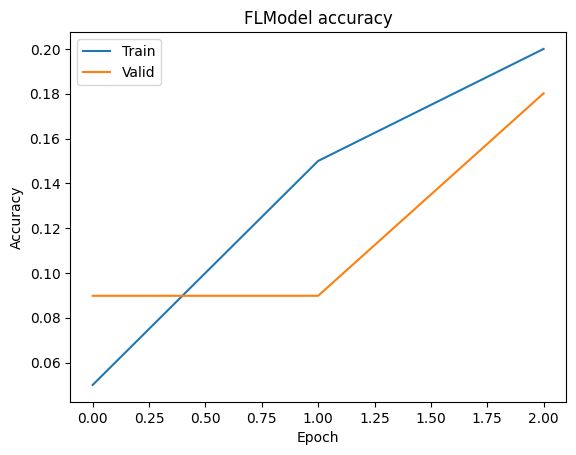

In [8]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history["global_history"]['multiclassaccuracy'])
plt.plot(history["global_history"]['val_multiclassaccuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()